In [4]:
import pyodbc
import pandas as pd

# ODBC connection string
conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=.\\SQLEXPRESS01;"
    "Database=HighCourtDB1;"
    "Trusted_Connection=yes;"
)

conn = pyodbc.connect(conn_str)
cursor = conn.cursor()
cursor.execute("SELECT * FROM HighCourtCases")

rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
df = pd.DataFrame.from_records(rows, columns=columns)
print(df.head(90))

cursor.close()
conn.close()


    Case_id Country CalendarDay         HighCourtName  \
0         1   India  2025-09-16  Allahabad High Court   
1         2   India  2025-09-16  Allahabad High Court   
2         3   India  2025-09-16  Allahabad High Court   
3         4   India  2025-09-16  Allahabad High Court   
4         5   India  2025-09-16     Bombay High Court   
..      ...     ...         ...                   ...   
85       86   India  2025-09-16     Madras High Court   
86       87   India  2025-09-16     Madras High Court   
87       88   India  2025-09-16     Madras High Court   
88       89   India  2025-09-16      Patna High Court   
89       90   India  2025-09-16      Patna High Court   

                        HighCourtBench CourtCaseType  \
0                      Allahabad Bench         Civil   
1                      Allahabad Bench      Criminal   
2   Allahabad High Court Lucknow Bench         Civil   
3   Allahabad High Court Lucknow Bench      Criminal   
4                  Bench at Auranga

In [5]:
# Renaming the features
rename_map = {
    "Case_id": "case_id",
    "Country": "country",
    "CalendarDay": "calendar_day",
    "HighCourtName": "high_court_name",
    "HighCourtBench": "high_court_bench",
    "CourtCaseType": "court_case_type",
    "CasesInstitutedLastMonth": "instituted_last_month",
    "CasesDisposedLastMonth": "disposed_last_month",
    "PendingCasesLessThan1Yr": "pending_lt1y",
    "PendingCases1To3Yr": "pending_1to3y",
    "PendingCases3To5Yr": "pending_3to5y",
    "PendingCases5To10Yr": "pending_5to10y",
    "PendingCasesAbove10Yr": "pending_gt10y",
    "WritPetitionCases": "writ_cases",
    "SecondAppealCases": "second_appeal_cases",
    "FirstAppealCases": "first_appeal_cases",
    "AppealCases": "appeal_cases",
    "PetitionCases": "petition_cases",
    "RevisionCases": "revision_cases",
    "ReferenceCases": "reference_cases",
    "SuitCases": "suit_cases",
    "ReviewCases": "review_cases",
    "ApplicationCases": "application_cases",
    "CasesInstitutedCurrentYear": "instituted_current_year",
    "CasesDisposedCurrentYear": "disposed_current_year",
}

df.rename(columns=rename_map, inplace=True)

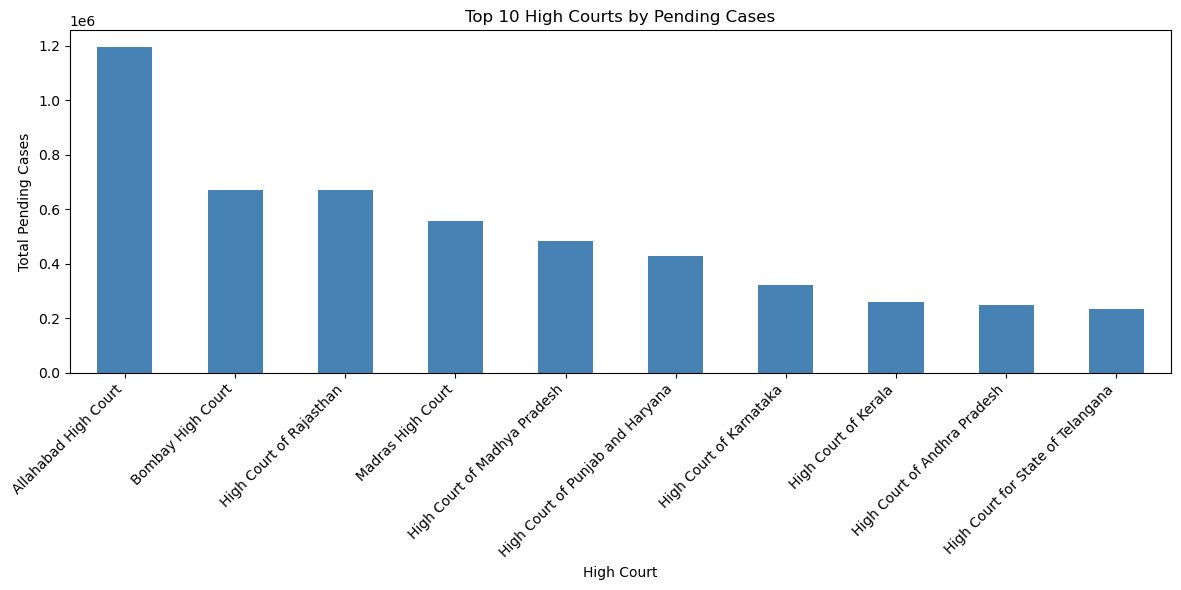

In [7]:
# ================================================================
# 1️⃣ Pending Cases per High Court
# ================================================================
df["total_pending"] = (
    df["pending_lt1y"] + df["pending_1to3y"] + df["pending_3to5y"]
    + df["pending_5to10y"] + df["pending_gt10y"]
)

pending_summary = (
    df.groupby("high_court_name")["total_pending"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
pending_summary.head(10).plot(kind="bar", color="steelblue")
plt.title("Top 10 High Courts by Pending Cases")
plt.xlabel("High Court")
plt.ylabel("Total Pending Cases")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


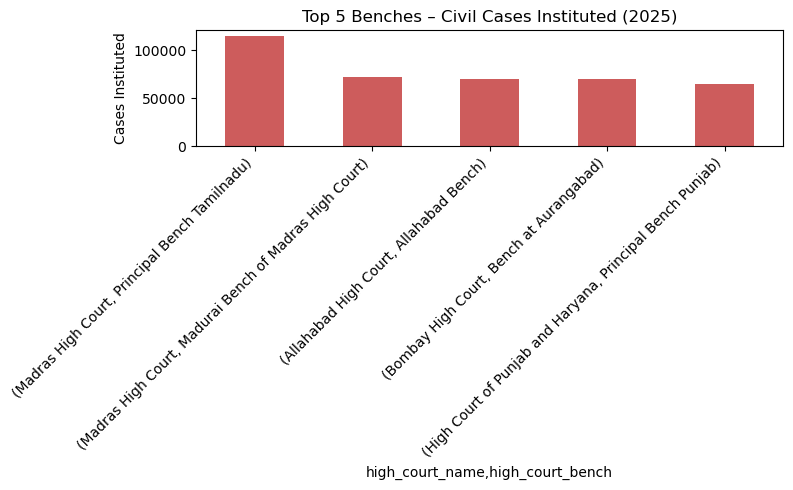

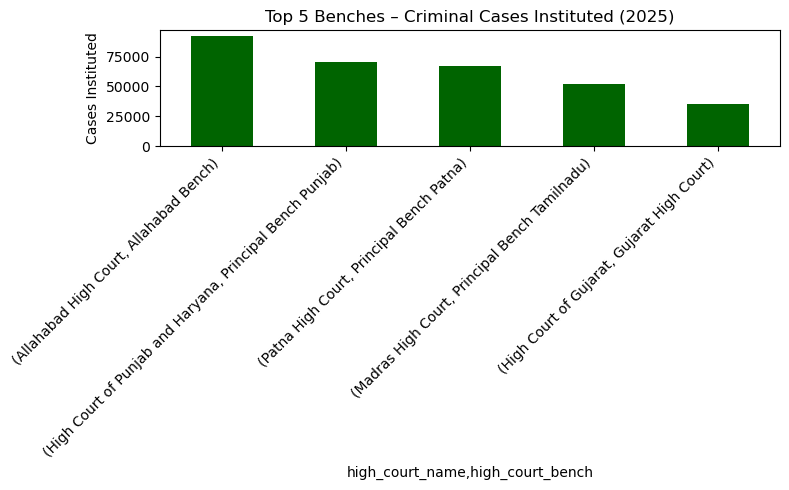

In [8]:
# ================================================================
# 2️⃣ Top 5 Civil and Criminal Benches
# ================================================================
civil_df = df[df["court_case_type"].str.contains("Civil", case=False, na=False)]
criminal_df = df[df["court_case_type"].str.contains("Criminal", case=False, na=False)]

top_civil = (
    civil_df.groupby(["high_court_name", "high_court_bench"])["instituted_current_year"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

top_criminal = (
    criminal_df.groupby(["high_court_name", "high_court_bench"])["instituted_current_year"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# Civil chart
plt.figure(figsize=(8,5))
top_civil.plot(kind="bar", color="indianred")
plt.title("Top 5 Benches – Civil Cases Instituted (2025)")
plt.ylabel("Cases Instituted")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Criminal chart
plt.figure(figsize=(8,5))
top_criminal.plot(kind="bar", color="darkgreen")
plt.title("Top 5 Benches – Criminal Cases Instituted (2025)")
plt.ylabel("Cases Instituted")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


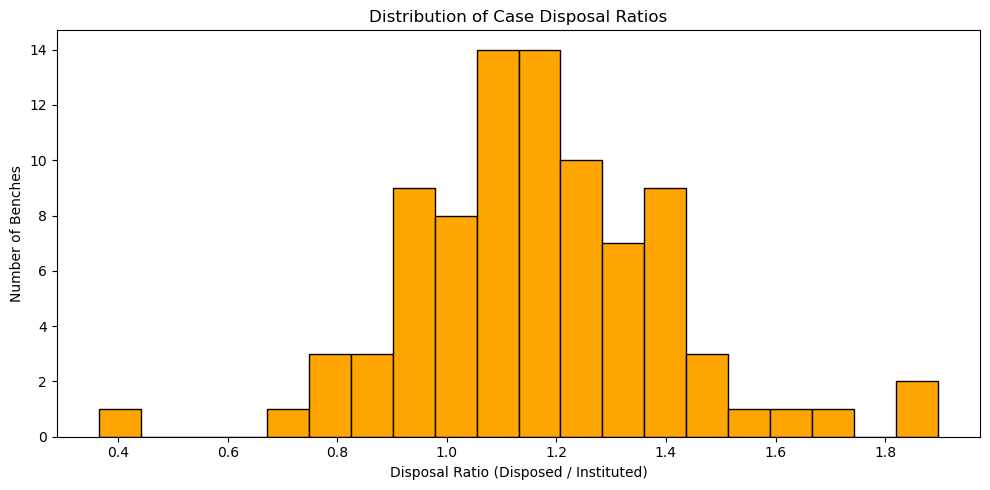

In [9]:
# ================================================================
# 3️⃣ Case Disposal Ratios
# ================================================================
df["disposal_ratio"] = np.where(
    df["instituted_current_year"] > 0,
    df["disposed_current_year"] / df["instituted_current_year"],
    np.nan
)

plt.figure(figsize=(10,5))
plt.hist(df["disposal_ratio"].dropna(), bins=20, color="orange", edgecolor="black")
plt.title("Distribution of Case Disposal Ratios")
plt.xlabel("Disposal Ratio (Disposed / Instituted)")
plt.ylabel("Number of Benches")
plt.tight_layout()
plt.show()


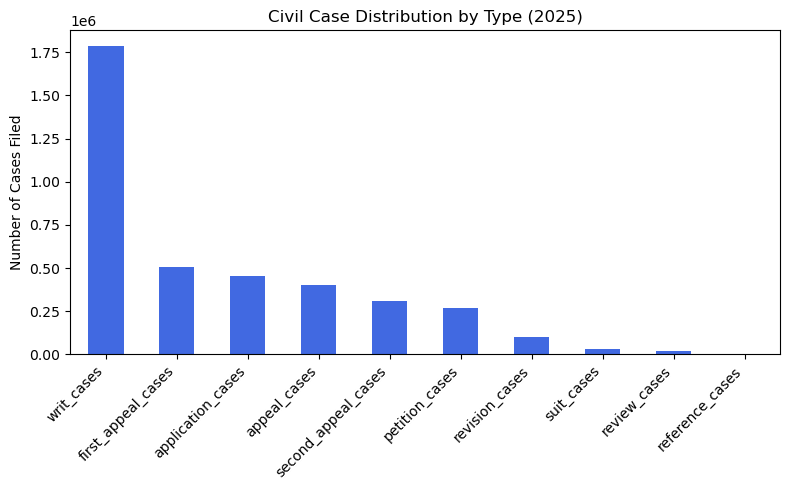

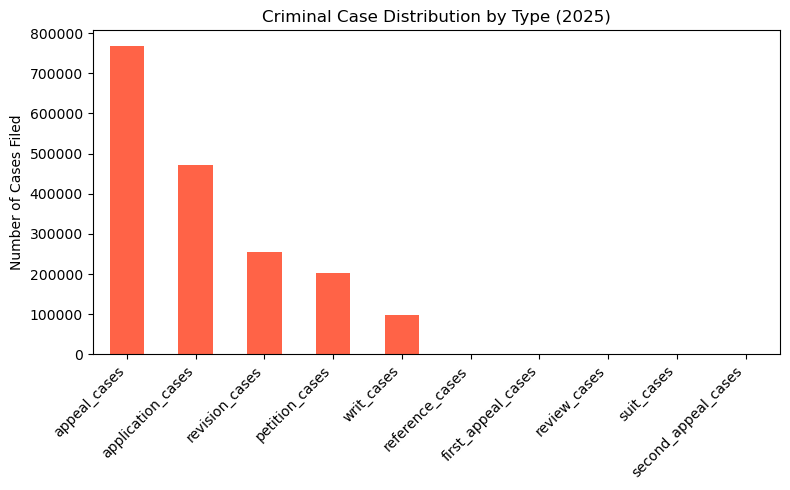

In [10]:
# ================================================================
# 4️⃣ Civil & Criminal Case Types Distribution
# ================================================================
case_columns = [
    "writ_cases", "second_appeal_cases", "first_appeal_cases", "appeal_cases",
    "petition_cases", "revision_cases", "reference_cases", "suit_cases",
    "review_cases", "application_cases"
]

civil_totals = civil_df[case_columns].sum().sort_values(ascending=False)
criminal_totals = criminal_df[case_columns].sum().sort_values(ascending=False)

# Civil types chart
plt.figure(figsize=(8,5))
civil_totals.plot(kind="bar", color="royalblue")
plt.title("Civil Case Distribution by Type (2025)")
plt.ylabel("Number of Cases Filed")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Criminal types chart
plt.figure(figsize=(8,5))
criminal_totals.plot(kind="bar", color="tomato")
plt.title("Criminal Case Distribution by Type (2025)")
plt.ylabel("Number of Cases Filed")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


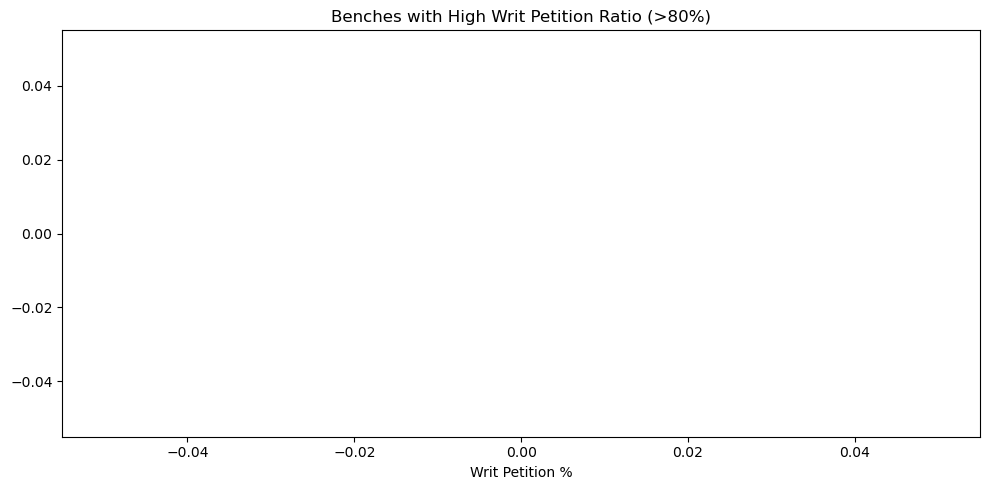

In [11]:
# ================================================================
# 5️⃣ Writ Petition % per Bench
# ================================================================
df["total_cases"] = df[case_columns].sum(axis=1)
df["writ_ratio"] = np.where(df["total_cases"] > 0, df["writ_cases"] / df["total_cases"] * 100, 0)

high_writ = df[df["writ_ratio"] > 80]
plt.figure(figsize=(10,5))
plt.barh(high_writ["high_court_bench"], high_writ["writ_ratio"], color="slateblue")
plt.title("Benches with High Writ Petition Ratio (>80%)")
plt.xlabel("Writ Petition %")
plt.tight_layout()
plt.show()


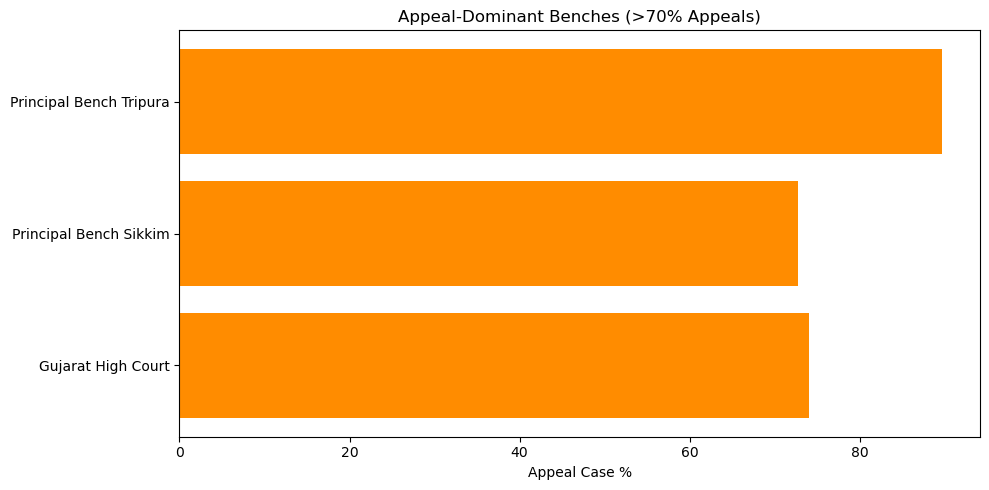

In [12]:
# ================================================================
# 6️⃣ Appeal-Dominant Courts
# ================================================================
df["appeal_ratio"] = np.where(df["total_cases"] > 0, df["appeal_cases"] / df["total_cases"] * 100, 0)
appeal_dominant = df[df["appeal_ratio"] > 70]

plt.figure(figsize=(10,5))
plt.barh(appeal_dominant["high_court_bench"], appeal_dominant["appeal_ratio"], color="darkorange")
plt.title("Appeal-Dominant Benches (>70% Appeals)")
plt.xlabel("Appeal Case %")
plt.tight_layout()
plt.show()


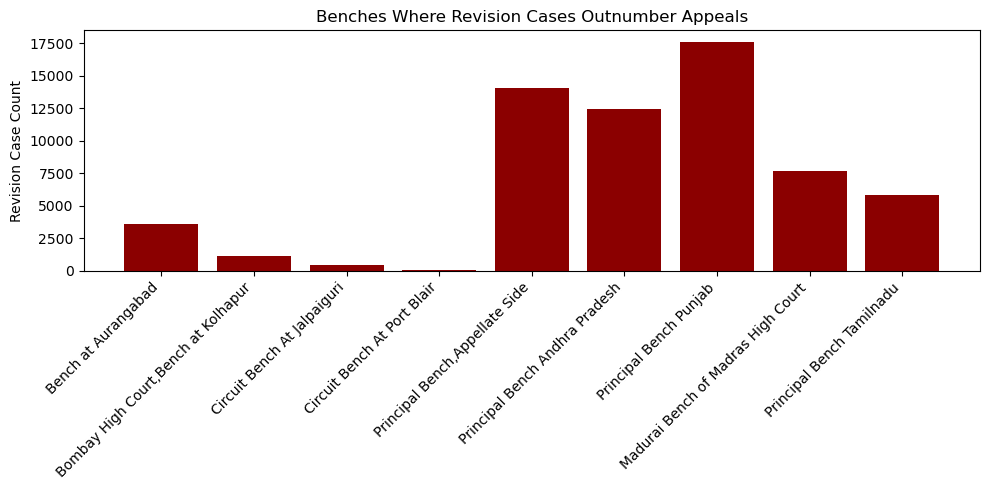

In [13]:
# ================================================================
# 7️⃣ Revision > Appeal Cases
# ================================================================
revision_heavy = df[df["revision_cases"] > df["appeal_cases"]]
plt.figure(figsize=(10,5))
plt.bar(revision_heavy["high_court_bench"], revision_heavy["revision_cases"], color="darkred")
plt.title("Benches Where Revision Cases Outnumber Appeals")
plt.ylabel("Revision Case Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


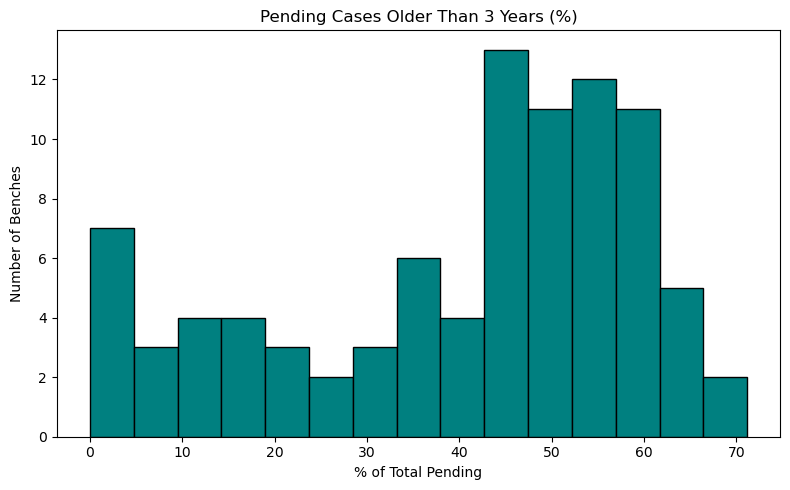

Average % of Pending Cases Older Than 3 Years: 40.35%


In [14]:
# ================================================================
# 8️⃣ Pending >3 Years
# ================================================================
df["pct_above_3y"] = np.where(
    df["total_pending"] > 0,
    (df["pending_3to5y"] + df["pending_5to10y"] + df["pending_gt10y"]) / df["total_pending"] * 100,
    0
)

avg_long_pending = df["pct_above_3y"].mean()

plt.figure(figsize=(8,5))
plt.hist(df["pct_above_3y"], bins=15, color="teal", edgecolor="black")
plt.title("Pending Cases Older Than 3 Years (%)")
plt.xlabel("% of Total Pending")
plt.ylabel("Number of Benches")
plt.tight_layout()
plt.show()

print(f"Average % of Pending Cases Older Than 3 Years: {avg_long_pending:.2f}%")
